In [1]:
# Character CNN model from https://doi.org/10.3390/app131911104

In [2]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re
from html import unescape
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
# Data cleaning from https://doi.org/10.3390/app131911104
def preprocess_text(text):
    
    # Step 1: Decoding HTML
    decoded_text = unescape(text)
    
    # Step 2: Removal of emoticons
    decoded_text = re.sub(r'[\U00010000-\U0010ffff]', '', decoded_text)
    
    # Step 3: Removal of mentions (usernames)
    decoded_text = re.sub(r'@\w+', '', decoded_text)
    
    # Step 4: Removal of URL links
    decoded_text = re.sub(r'https?://\S+|www\.\S+', '', decoded_text)
    
    # Step 5: Conversion to lower case
    decoded_text = decoded_text.lower()
    
    # Step 6: Expansion of negations
    decoded_text = re.sub(r"can't", 'cannot', decoded_text)
    # Add more negations as needed
    
    # Step 7: Removal of hashtags, punctuation marks, numbers, and special characters
    decoded_text = re.sub(r'#[\w_]+', '', decoded_text)
    decoded_text = re.sub(r'[^a-zA-Z\s]', '', decoded_text)
    
    # Step 8: Removal of extra white spaces
    decoded_text = re.sub(r'\s+', ' ', decoded_text).strip()
    
    return decoded_text
    

In [4]:
def text_to_one_hot(text):
    
    # English character set
    alphabet = "abcdefghijklmnopqrstuvwxyz "
    unknown_char = "UNK"

    # Create character-to-index mapping
    char_to_index = {char: i for i, char in enumerate(alphabet, start=1)}  # Start index from 1
    char_to_index[unknown_char] = 0  # Index 0 for unknown characters

    # Preprocess input text
    preprocessed_text = preprocess_text(text)

    # Tokenize the text into character indices
    tokenized_text = [char_to_index.get(char.lower(), char_to_index[unknown_char]) for char in preprocessed_text]

    # Zero-pad to fix the length to 330 characters -> Max length of input texts is 349 without preprocess, 326 with preprocess
    max_length = 330
    padded_text = pad_sequences([tokenized_text], maxlen=max_length, padding='post', truncating='post')[0]

    # One-hot encoding
    one_hot_encoding = np.eye(len(alphabet) + 1)[padded_text]  # +1 for the unknown character

    return one_hot_encoding
    

In [5]:
# Load datasets
train_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_train.csv")
test_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_test.csv")

# Text preprocessing
X_train_one_hot = train_df['text'].apply(text_to_one_hot)
X_test_one_hot = test_df['one_hot'] = test_df['text'].apply(text_to_one_hot)

# Binary label encoding
y_train = (train_df['label'] == 'hate').astype(int)
y_test = (test_df['label'] == 'hate').astype(int)

# Convert pandas series to tensorflow tensors
X_train_tensor = tf.convert_to_tensor(X_train_one_hot.tolist(), dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_one_hot.tolist(), dtype=tf.float32)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [6]:
input_shape = (330, 28)

model = Sequential([
    
    # Three convolution layers
    Conv1D(100, kernel_size=3, strides=1, padding='valid', activation='relu', input_shape=input_shape),
    Conv1D(100, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),
    Conv1D(100, kernel_size=3, strides=1, padding='valid', activation='relu'),
    MaxPooling1D(pool_size=3),
    
    # Flatten layer
    Flatten(),

    # Two fully connected layers with dropout
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(units=1, activation='sigmoid')
])



In [7]:
# Hyperparameters
epochs = 10
batch_size = 32
learning_rate = 0.001

In [8]:
# Compile the model
model.compile(loss='binary_crossentropy',  optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 328, 100)          8500      
                                                                 
 conv1d_1 (Conv1D)           (None, 326, 100)          30100     
                                                                 
 max_pooling1d (MaxPooling1  (None, 108, 100)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 106, 100)          30100     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 100)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 3500)              0

In [9]:
# Early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_tensor, y_train, epochs=10, batch_size=32, validation_split=0.2)#, callbacks=[callback])

Epoch 1/10


48/48 [==============================] - 4s 54ms/step - loss: 0.6866 - accuracy: 0.6094 - val_loss: 0.6483 - val_accuracy: 0.6684
Epoch 2/10
48/48 [==============================] - 3s 52ms/step - loss: 0.6364 - accuracy: 0.6401 - val_loss: 0.6191 - val_accuracy: 0.6710
Epoch 3/10
48/48 [==============================] - 3s 55ms/step - loss: 0.6217 - accuracy: 0.6610 - val_loss: 0.6099 - val_accuracy: 0.6684
Epoch 4/10
48/48 [==============================] - 3s 57ms/step - loss: 0.6036 - accuracy: 0.6878 - val_loss: 0.6342 - val_accuracy: 0.6606
Epoch 5/10
48/48 [==============================] - 3s 55ms/step - loss: 0.5617 - accuracy: 0.7178 - val_loss: 0.6016 - val_accuracy: 0.6606
Epoch 6/10
48/48 [==============================] - 3s 53ms/step - loss: 0.4127 - accuracy: 0.8321 - val_loss: 0.7289 - val_accuracy: 0.6684
Epoch 7/10
48/48 [==============================] - 2s 49ms/step - loss: 0.2468 - accuracy: 0.9059 - val_loss: 1.0142 - val_accuracy: 0.6606
Epoch 8/10


In [10]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
     
    fig, ax = plt.subplots(figsize=(15, 4))
 
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
         
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
     
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, epochs-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()
    

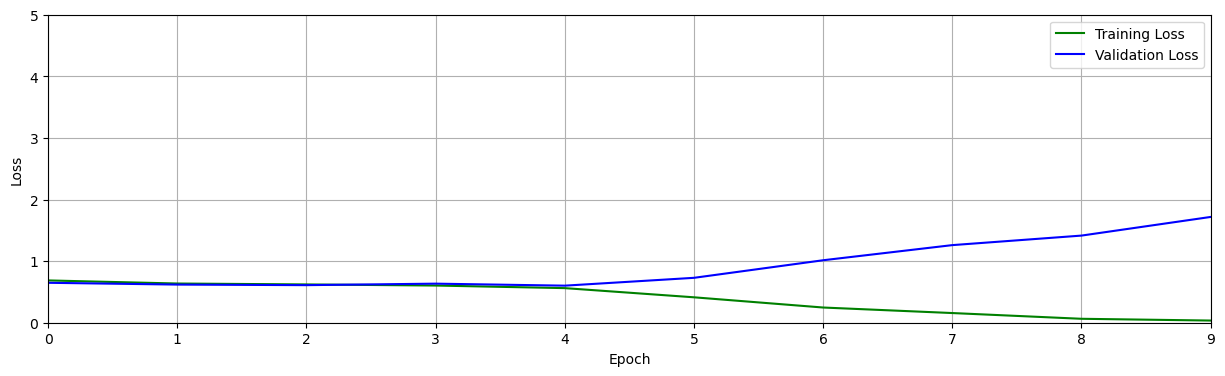

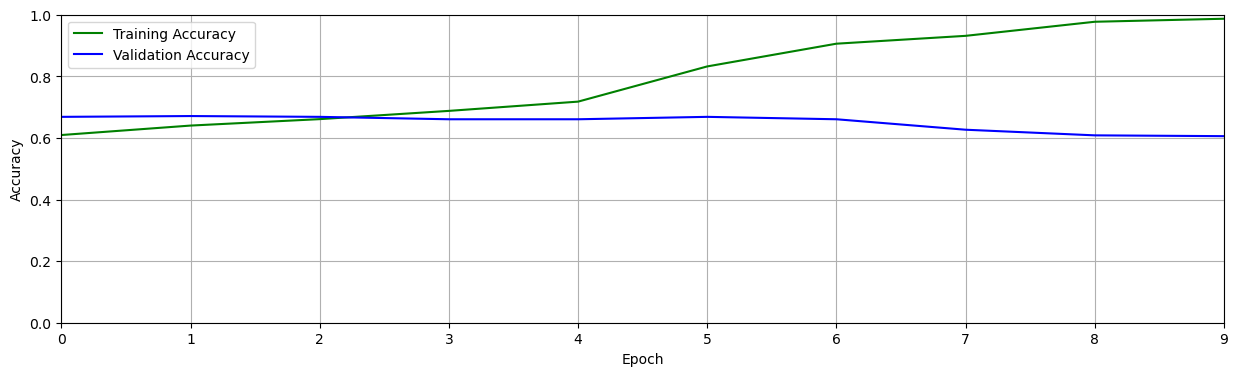

In [12]:
# Retrieve training results
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 2.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])